# Materials:  

1. https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook  
2. https://www.youtube.com/watch?v=URJ9pP1aURo&t=1130s  
3. https://medium.com/analytics-vidhya/neural-network-mnist-classifier-from-scratch-using-numpy-library-94bbcfed7eae  
4. https://www.youtube.com/watch?v=w8yWXqWQYmU

# Data and libs

In [1]:
import pandas as pd
import numpy as np 
from keras.datasets import mnist

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
print(
    f' Train type: {type(train_X)}\n',
    f'Train shape: {train_X.shape}\n',
    f'Train type: {type(test_X)}\n',
    f'Train shape: {test_X.shape}\n', 
    f'Train target shape: {train_y.shape}\n',
    f'Train unique values: {set(train_y)}'
)

 Train type: <class 'numpy.ndarray'>
 Train shape: (60000, 28, 28)
 Train type: <class 'numpy.ndarray'>
 Train shape: (10000, 28, 28)
 Train target shape: (60000,)
 Train unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


# Functions

In [4]:
def batch_preparation(batch, max_val = 255): 
    '''flatten 28*28 image to 728*1
       and 
       devide on maximum value
           return: (len batch) x (len sample of batch)
    '''
    prep_batch = batch.reshape(len(batch), 784) / max_val
    return prep_batch


def test_batch_preparation(test_batch): 
    '''Test batch_preparation'''
    l,r,c = test_batch.shape
    prep_batch = batch_preparation(test_batch)
    assert prep_batch.shape[0] == l, 'Wrong number of elements in batch'
    assert prep_batch.shape[1] == r * c, 'Wrong size of flatten matrix'
    assert (prep_batch <=1).all(), 'Batch is not normalized'
    return 1

In [5]:
print(batch_preparation(train_X[:2]).shape)
test_batch_preparation(train_X[:2])

(2, 784)


1

In [6]:
def init_params(input_size = 784, l1_size = 10, l2_size = 10): 
    W1 = np.random.rand(l1_size, input_size) - 0.5
    b1 = np.random.rand(l1_size, 1) - 0.5
    W2 = np.random.rand(l2_size, l1_size) - 0.5
    b2 = np.random.rand(l2_size, 1) - 0.5
    return W1, b1, W2, b2

In [7]:
def ReLU(x):
    return np.maximum(x,0)

def dReLU(x): 
    return 1 * (x > 0)

def softmax(x): 
    return np.exp(x)/np.sum(np.exp(x), axis=0)

In [8]:
def forward_prop(W1, b1, W2, b2, X): 
    # input len of one sample = 784
    # m = batch len
    # X: m x 784
    # X.T: 784 x m
    # W1: l1 x 784
    
    Z1 = W1.dot(X.T) + b1 # (l1 x 784) x (784 x m) = (l1 x m)
    A1 = ReLU(Z1) # (10 x m)
    Z2 = W2.dot(A1) + b2  # (l2 x l1) x (l1 x m) = (l2 x m)
    A2 = softmax(Z2) # (l2 x m)
    return Z1, A1, Z2, A2

In [9]:
def test_forward_prop(batch, l1_size = 10, l2_size = 10): 
    ''''''
    # input data:
    prep_batch = batch_preparation(batch).T
    num_samples = prep_batch.shape[1]
    tW1, tb1, tW2, tb2 = init_params()
    
    # First layer (Z1: l1_size x num_samples)
    tZ1 = tW1.dot(prep_batch) + tb1
    assert tZ1.shape == (l1_size, num_samples), 'Error on first layer'
    print(f'Shape after Z1 layer:{tZ1.shape}')
    #print(tZ1)
    
    # First activation(tA1 ~ Z1: l1_size x num_samples)
    tA1 = ReLU(tZ1)
    assert tA1.shape == tZ1.shape, 'Error on first activation'
    assert (tA1 >= 0).all(), 'There are negative values after ReLU'
    #print(tA1, tA1.shape)
    
    # Z2 (l2_size x m)
    tZ2 = tW2.dot(tA1) + tb2
    assert tZ2.shape == (l2_size, num_samples), 'Error on second layer'
    print(f'Shape after Z2 layer:{tZ2.shape}')
    #print(tZ2)
    
    # tA2 ~ Z2 (l2_size x m)
    return tZ2
    tA2 = softmax(tZ2)
    assert tZ2.shape == (l2_size, num_samples), 'Error on second activation'
    assert np.allclose(np.sum(tA2[0:,]),tA2.shape[1]), 'Error with softmax'
    return 1

In [10]:
t = test_forward_prop(train_X[:2])

Shape after Z1 layer:(10, 2)
Shape after Z2 layer:(10, 2)


In [11]:
def ohe_target(x):
    ''''''
    return np.array(
        [[0 if i != j else 1 for i in range(10)] for j in x]).T

In [12]:
# check ohe_target
t = ohe_target([3,2,1])
print(t)
del t

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [13]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    ''''''
    
    ohe_y = ohe_target(Y) # l2 x m
    batch_size = len(X) # == m
    
    dZ2 = A2 - ohe_y # l2 x m
    dW2 = (1/batch_size) * dZ2.dot(A1.T) # const * (l2 x m) x (m xl2)= l2 x l2
    db2 = (1/batch_size) * np.sum(dZ2, axis=1).reshape(10,1) # (l2 x 1)
    
    dZ1 = W2.T.dot(dZ2)  * dReLU(Z1) # (l1xl2) x (l2 x m) * (l1 x m)
    dW1 = (1/batch_size) * dZ2.dot(X) # (l2 x m) x (m x 784)
    db1 = (1/batch_size) * np.sum(dZ1, axis=1).reshape(10,1) #l2 x 1
    return dW1, db1, dW2, db2

In [14]:
def batch_cross_entropy_loss(forward_outputs, targets):
    ''''''
    ohe_targets = ohe_target(targets)
    cross_entropy = (1/len(targets)) * np.sum(forward_outputs * ohe_targets)
    return -cross_entropy

In [15]:
def update_nn_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr= 0.01):
    ''''''
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    return W1, b1, W2, b2

In [16]:
def generate_batch_indexes(data_size, batch_size):
    '''generate indexes to get randomly batchs of images'''
    a = np.array(range(data_size))
    np.random.shuffle(a)
    for n in range(data_size//batch_size):
        yield a[batch_size*n:batch_size*(n+1)]
        
def test_generate_batch_indexes():
    return generate_batch_indexes(1000, 30)

In [17]:
def plot_digit(x):
    '''plot one digit'''
    plt.imshow(x)
    plt.show()

In [18]:
def zero_grad(dW1, db1, dW2, db2):
    return np.zeros_like(dW1), np.zeros_like(db1), np.zeros_like(dW2), np.zeros_like(db2)

In [19]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

# Train, predict and plot results

In [20]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

Epoch number: 50/50
Score on train : 0.90
Score on test : 0.90


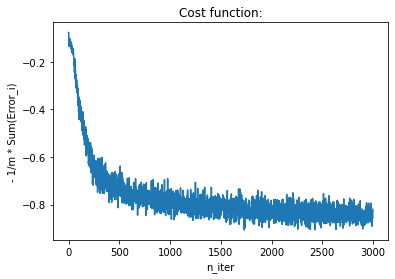

In [21]:
n_epochs = 50
lr = 5e-3, 

batch_size = 100
num_samples = len(train_X)

# init models params:
W1, b1, W2, b2 = init_params()

w1_shape = W1.shape
b1_shape = b1.shape

loss_li = []
for epoch in range(n_epochs):
        
    shuffled_inxes = generate_batch_indexes(num_samples, batch_size)
    for n, ind in enumerate(shuffled_inxes):

        # get batch:
        batch = train_X[ind]
        batch = batch_preparation(batch)

        # get targets:
        targets = train_y[ind]

        # calc forward pass:
        Z1, A1, Z2, A2 = forward_prop(
            W1, b1, W2, b2, batch)

        # calculate loss: 
        loss = batch_cross_entropy_loss(A2, targets)

        # save loss: 
        if n % 10 == 0:
            loss_li.append(loss)

        # calc backward propagation: 
        dW1, db1, dW2, db2 = backward_prop(
            Z1, A1, Z2, A2, W1, W2, batch, targets)

        # update nn params: 
        W1, b1, W2, b2 = update_nn_params(
            W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        
        # check shapes:
        assert W1.shape == w1_shape, 'Wrong W1 shape'
        assert b1_shape == b1.shape, 'Wrong b1 shape'
        
        # zero gradients: 
        dW1, db1, dW2, db2 = zero_grad(dW1, db1, dW2, db2)
    
    data_types = ['train', 'test']
    data_li = [train_X, test_X]
    targets_li = [train_y, test_y]
    
    print(f'Epoch number: {epoch + 1}/{n_epochs}')
    
    for type_, data_, targets_ in zip(data_types, data_li, targets_li):
        _, _, _, curA2 = forward_prop(
            W1, b1, W2, b2, batch_preparation(data_))
        preds_ = get_predictions(curA2)
        score_ = get_accuracy(preds_, targets_)
        print(f'Score on {type_} : {score_:.2f}')
    
    plt.plot(loss_li)
    plt.title('Cost function:')
    plt.ylabel('- 1/m * Sum(Error_i)')
    plt.xlabel('n_iter')
    plt.show()
    clear_output(True)